# Sparsity-Promoting Dynamic Mode Decomposition
In this tutorial we present a variant of DMD called *Sparsity-Promoting* DMD. The algorithm differs from the original one in the way it computes DMD modes amplitudes, since SpDMD "promotes" combinations of amplitudes with an high number of amplitudes set to 0. Such a quality of DMD amplitudes (and of matrix in general) is called *sparsity*. The parameter $\gamma$ controls how much sparsity is promoted.

SpDMD has been presented in *Sparsity-promoting dynamic mode decomposition*, (https://doi.org/10.1063/1.4863670). The algorithm uses ADMM (see *Distributed optimization and statistical learning via the alternating
direction method of multipliers*, http://dx.doi.org/10.1561/2200000016), an iterative algorithm used to solve optimization problems.

First of all, we import the modules needed for this tutorial.

In [1]:
import numpy as np
from pydmd import SpDMD,DMD
import matplotlib.pyplot as plt

We consider several values of the parameter $\gamma$ in order to check how it affects the result:

In [2]:
gammas = [1.e-3,2,10,20,30,50,100,1000]

As $\gamma \to 0$, SpDMD approaches to standard DMD algorithm, which does not impose sparsity in the result.

We now load a dataset related to an heat conductivity problem:

In [6]:
X = np.load('../data/heat_90.npy')
X.shape

(441, 100)

We use the dataset to train several instances of SpDMD (one for each $\gamma$ taken into account). We also create an instance of standard DMD for comparison:

In [4]:
spdmd_list = [SpDMD(svd_rank=30,gamma=gm,rho=1.e4).fit(X) for gm in gammas]
std_dmd = DMD(svd_rank=30).fit(X)

/Users/francescoandreuzzi/.local/share/virtualenvs/parametric-dmd-FqHiOHMJ/lib/python3.8/site-packages/pydmd/dmdbase.py:348: UserWarning: Input data matrix X has condition number 5.662682003232569e+18. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  warnings.warn(


ADMM: 10000 iterations
ADMM: 10000 iterations
ADMM: 4 iterations
ADMM: 4 iterations
ADMM: 4 iterations
ADMM: 4 iterations
ADMM: 4 iterations
ADMM: 3 iterations


As you can see each call to the method `SpDMD.fit()` prints the number of iterations of ADMM. You can suppress this output passing the flag `verbose=False` to the constructor of the class `SpDMD`:

In [5]:
SpDMD(svd_rank=30,gamma=10,rho=1.e2,verbose=False).fit(X);

You can control the number of iterations with the parameter `rho` of the constructor of the class `SpDMD`. The optimal value for this parameter may differ for different problems (reference: https://doi.org/10.3182/20120914-2-US-4030.00038).

In [12]:
SpDMD(svd_rank=30,gamma=10,rho=1.e4).fit(X)
SpDMD(svd_rank=30,gamma=10,rho=1).fit(X);

/Users/francescoandreuzzi/.local/share/virtualenvs/parametric-dmd-FqHiOHMJ/lib/python3.8/site-packages/pydmd/dmdbase.py:348: UserWarning: Input data matrix X has condition number 5.662682003232569e+18. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  warnings.warn(


ADMM: 4 iterations
ADMM: 1933 iterations


The maximum number of iterations of ADMM is $10^4$ by default, and can be tuned with the parameter `max_iterations` of the constructor of the class `SpDMD`.

## Sparsity-promoting amplitudes
We now examine the results of the experiment initialized above. First of all we plot the number of non-zero amplitudes in the algorithm as $\gamma$ increases. As you can see an high value of $\gamma$ "breaks" the algorithm, in the sense that all the DMD amplitudes are set to 0. By contrast, for low values of $\gamma$ SpDMD converges to standard DMD (all amplitudes are non-zero).

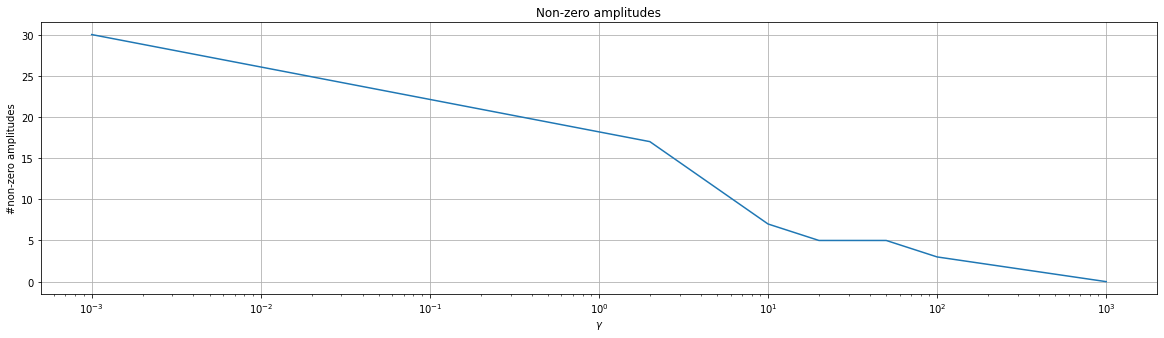

In [13]:
plt.figure(figsize=(20,5))

plt.plot(gammas, [np.count_nonzero(dmd.amplitudes) for dmd in spdmd_list])

plt.grid()
plt.xscale('log')

plt.title('Non-zero amplitudes')
plt.xlabel('$\gamma$')
plt.ylabel('#non-zero amplitudes')

plt.show()

In order to visualize the situation we plot the DMD ampltiudes for the tested values of $\gamma$.

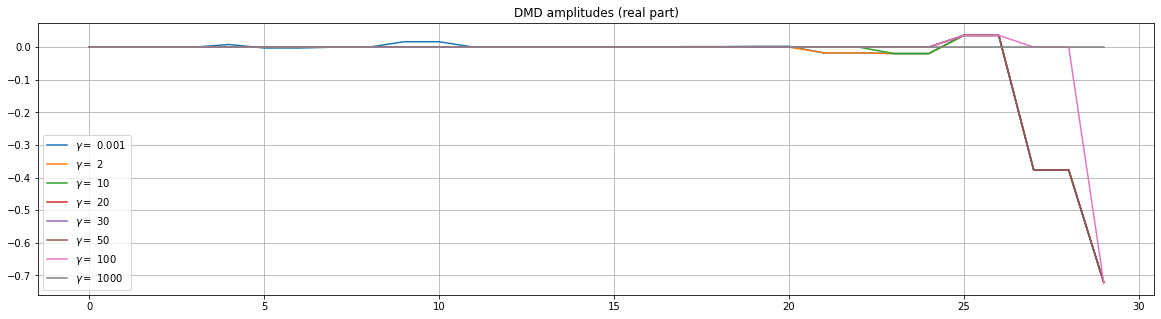

In [14]:
# plot amplitudes
plt.figure(figsize=(20,5))

for gm,a in zip(gammas,map(lambda dmd: dmd.amplitudes, spdmd_list)):
    plt.plot(a.real, label='$\gamma = $ {}'.format(gm))

plt.grid()
plt.legend()

plt.title('DMD amplitudes (real part)')

plt.show()

## Reconstruction and pointwise error
We use the instances of `SpDMD` and `DMD` constructed above to reconstruct the dataset for a particular time instance. Then, we evaluate the pointwise error for that time instance, and we compare the results for different values of $\gamma$.

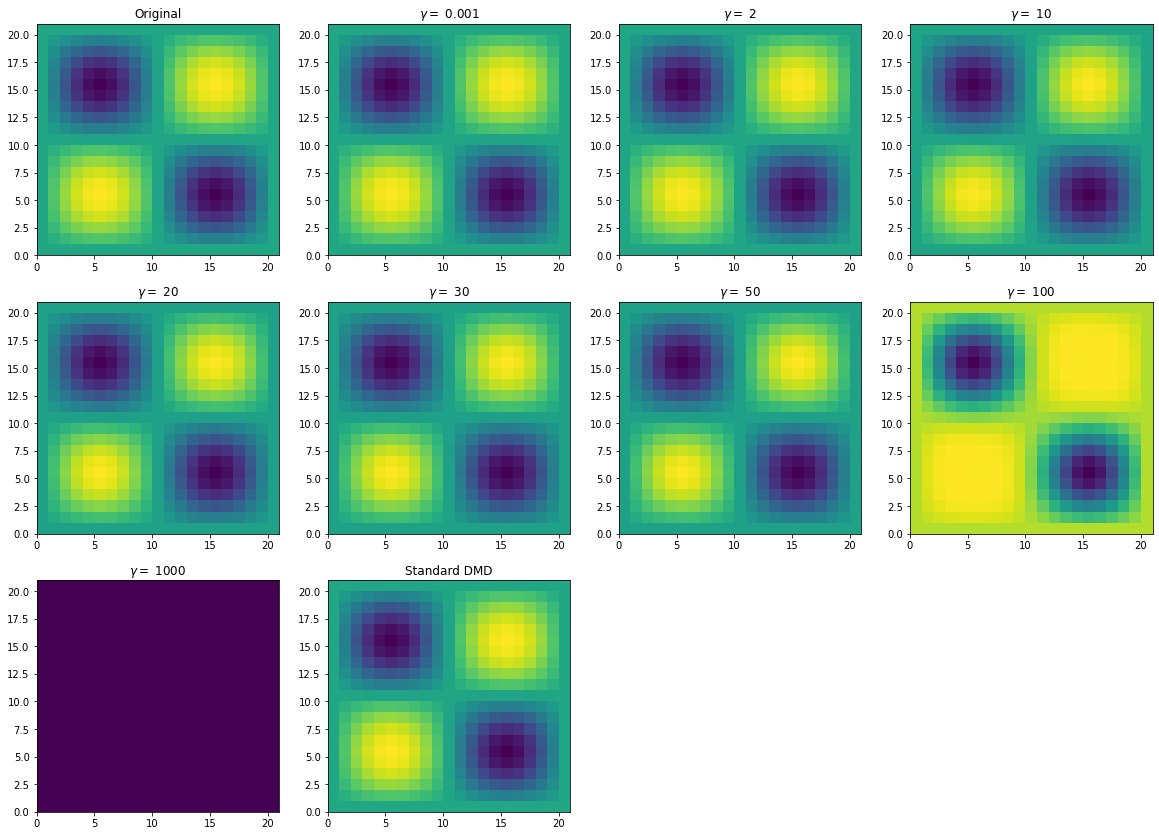

In [15]:
time = 2

plt.figure(figsize=(20,14.5))

plt.subplot(3,4,1)
plt.pcolormesh(X[:,time].reshape(21,21))
plt.title('Original')

for idx, gm, dmd in zip(range(len(gammas)), gammas, spdmd_list):
    plt.subplot(3,4,idx+2)
    plt.pcolormesh(dmd.reconstructed_data.real[:,time].reshape(21,21))
    
    plt.title('$\gamma =$ {}'.format(gm))
    
plt.subplot(3,4,len(gammas)+2)
plt.pcolormesh(std_dmd.reconstructed_data.real[:,time].reshape(21,21))
plt.title('Standard DMD')
    
plt.show()

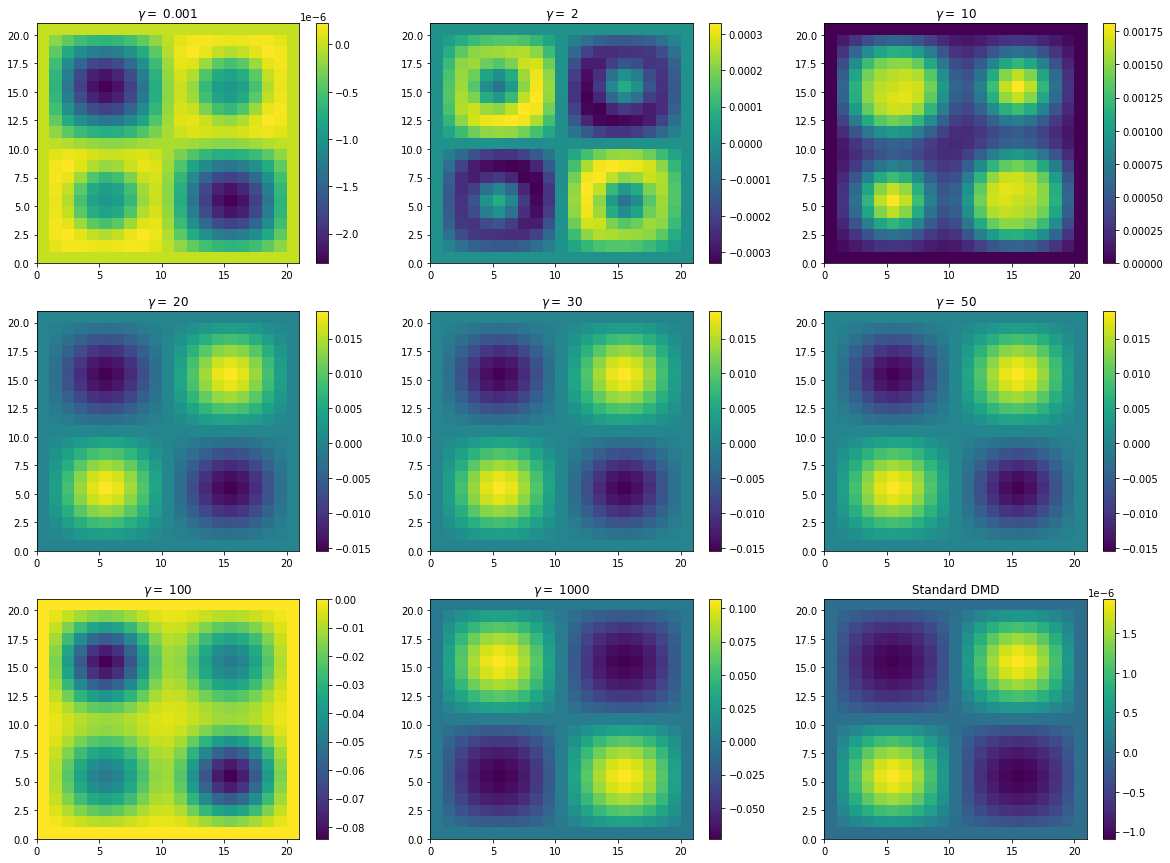

In [16]:
time = 2

plt.figure(figsize=(20,15))

for idx, gm, dmd in zip(range(len(gammas)), gammas, spdmd_list):
    plt.subplot(3,3,idx+1)
    
    plt.pcolormesh(dmd.reconstructed_data.real[:,time].reshape(21,21) - X[:,time].real.reshape(21,21))
    plt.colorbar()
    
    plt.title('$\gamma =$ {}'.format(gm))
    
plt.subplot(3,3,len(gammas)+1)
plt.pcolormesh(std_dmd.reconstructed_data.real[:,time].reshape(21,21) - X[:,time].real.reshape(21,21))
plt.colorbar()
plt.title('Standard DMD')
    
plt.show()

As you can see the errors provided by SpDMD and standard DMD are on similar magnitudes. The quality decreases as $\gamma$ grows, with the worst case happening when the number of non-zero amplitudes becomes 0.

## Comparison of the time evolution of absolute error

To end the comparison, we plot alongside the evolution of the absolute error (see the code below for our implementation of the function `absolute_error`) for the tested values of $\gamma$.

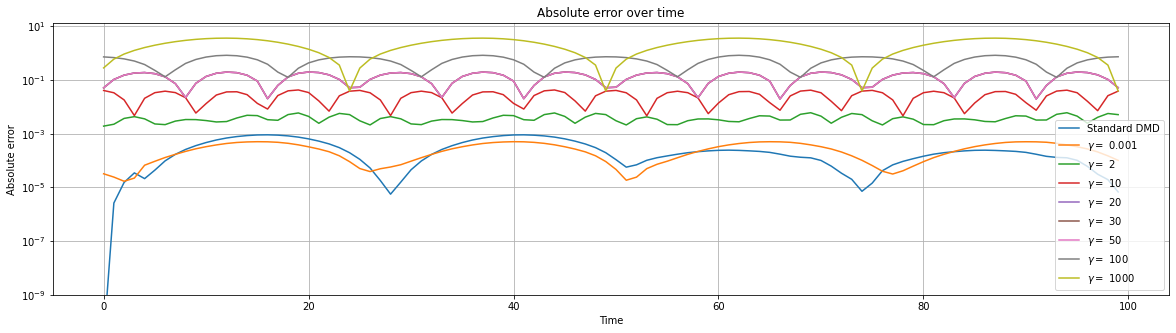

In [17]:
def relative_error(got, expected):
    return np.linalg.norm(got - expected) / np.linalg.norm(expected)

def absolute_error(got, expected):
    return np.linalg.norm(got - expected)

# gather data about absolute/relative error
errors = []
dmds = [*spdmd_list,std_dmd]
for dmd in dmds:
    e = []
    rec = dmd.reconstructed_data
    
    for time in range(X.shape[1]):
        e.append(absolute_error(rec[:,time], X[:,time]))
    
    errors.append(e)
errors = np.array(errors)

# plot the results
plt.figure(figsize=(20,5))

plt.plot(errors[-1], label='Standard DMD')

for gm,err in zip(gammas, errors):
    plt.plot(err, label='$\gamma =$ {}'.format(gm))
    
plt.legend()
plt.grid()

plt.yscale('log')
plt.ylim(bottom=1.e-9)

plt.xlabel('Time')
plt.ylabel('Absolute error')
plt.title('Absolute error over time')

plt.show()